In [1]:
!pip install qiskit
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Solving combinatorial optimization problems using QAOA

In this tutorial, we introduce combinatorial optimization problems, explain approximate optimization algorithms, explain how the Quantum Approximate Optimization Algorithm (QAOA) works and present the implementation of an example that can be run on a simulator or on a real quantum system.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

## Задача комбинаторной оптимизации

Задачи комбинаторной оптимизации включают поиск оптимального объекта из конечного набора объектов. Мы сосредоточимся на проблемах, связанных с
поиск «оптимальных» битовых строк, состоящих из 0 и 1 среди конечного набора битовых строк. Одной из таких задач, соответствующих графу, является задача Max-Cut.

### Проблема Max-Cut
Задача Max-Cut состоит в том, чтобы разбить узлы графа на два набора так, чтобы количество ребер между наборами было максимальным. Пример ниже
имеет граф с четырьмя узлами, и показаны некоторые способы его разделения на два набора, «красный» и «синий».

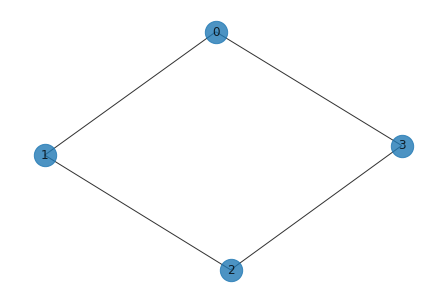

In [3]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

### The Mixing Unitary

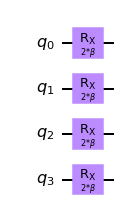

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes areconnected. 
# This matrix is given as a sparse matrix, so we need to convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()
nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

### The Problem Unitary

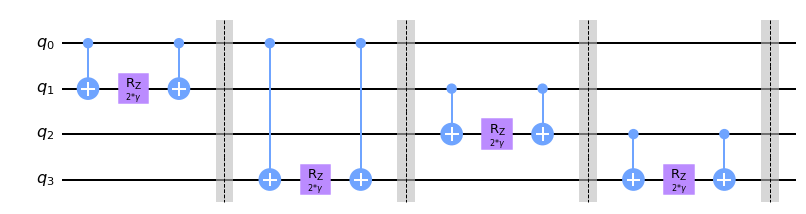

In [5]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw('mpl')

### Начальное состояние

Исходное состояние, используемое во время QAOA, обычно представляет собой равную суперпозицию всех базовых состояний, т.е.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n} $$

Такое состояние, когда количество кубитов равно 4 ($n=4$), может быть подготовлено путем применения вентилей Адамара, начиная с полностью нулевого состояния, как показано на рис.

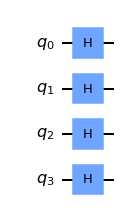

In [7]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

### Схема QAOA

До сих пор мы видели, что подготовка квантового состояния во время QAOA состоит из трех элементов.
- Подготовка начального состояния
- Применение унитарного $U(H_P) = e^{-i \gamma H_P}$, соответствующего гамильтониану задачи
- Применение смешивающего унитарного оператора $U(H_B) = e^{-i \beta H_B}$

Давайте посмотрим, как это выглядит для примера задачи:

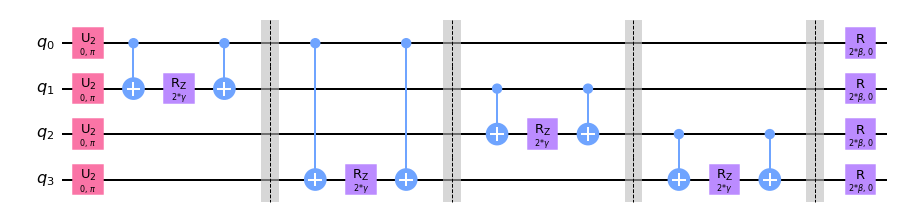

In [9]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [10]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [11]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

Note that different choices of classical optimizers are present in qiskit. We choose COBYLA as our classical optimization algorithm here.

### Analyzing the result

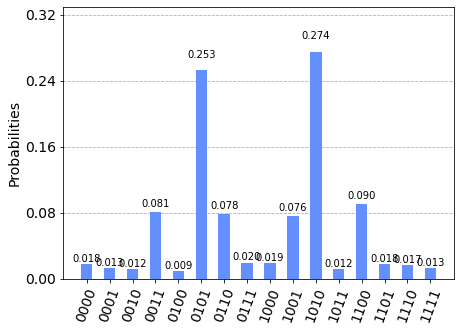

In [12]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

Как мы заметили, битовые строки «0101» и «1010» имеют наибольшую вероятность и действительно являются назначениями графа (с которого мы начали), который дает 4 ребра между двумя разделами.